# Exploratory Data Analysis of Blood Pressure GWAS Variants
- Annotations collected via Hail in the Google Cloud Platform to then enter this EDA script
- Missingness, relationship to dependent variable, and correlation between features visualised

- Many variant annotations have missing values and so during the Hail annotation had missing values replace with zeros (to avoid imputing bias values but still using the small about of true values present in those annotations) - I am not sure about the reliability of this approach.

In [1]:
# import libraries:

import re
import time
import warnings

import matplotlib as mpl
mpl.rcParams['figure.dpi'] = 300
import matplotlib.pylab as plt
import missingno as msno
import numpy as np
import pandas as pd
import seaborn as sns
import shap
from pulearn import BaggingPuClassifier, ElkanotoPuClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.impute import KNNImputer, SimpleImputer
from sklearn.metrics import (
    ConfusionMatrixDisplay,
    PrecisionRecallDisplay,
    RocCurveDisplay,
    accuracy_score,
    auc,
    classification_report,
    confusion_matrix,
    f1_score,
    precision_recall_curve,
    precision_recall_fscore_support,
    precision_score,
    recall_score,
    roc_auc_score,
    roc_curve,
)
from sklearn.model_selection import train_test_split
from xgboost import XGBClassifier

warnings.filterwarnings("ignore")

seed = 42

In [2]:
pd_table = pd.read_csv("BP_GWAS_data.csv")
pd_table['label'] = pd_table['label'].fillna(0)

In [3]:
features = pd_table.drop(["Gene", "CP"], axis=1)
features.shape

(42782, 92)

In [4]:
list(features)

['diagnosis',
 'star',
 'pathogenicity',
 'DANN.score',
 'CADD.raw_score',
 'CADD.PHRED_score',
 'gerp_scores.N',
 'gerp_scores.S',
 'BETAsbp',
 'BETAdbp',
 'BETApp',
 'minP',
 'motif_impact',
 'intergenic_impact',
 'regulatory_impact',
 'transcript_impact',
 'lof_HC',
 'polyphen_pred',
 'sift_pred',
 'polyphen_score',
 'sift_score',
 'motif_score_change',
 'GTEx_mean_proportion',
 'REVEL',
 'MVP',
 'GenoCanyon',
 'DEOGEN2',
 'integrated_fitCons',
 'LINSIGHT',
 'SiPhy_29way_logOdds',
 'bStatistic',
 'H3k9ac_signalValue',
 'H3k4me1_signalValue',
 'H3k4me2_signalValue',
 'H3k4me3_signalValue',
 'H4k20me1_signalValue',
 'H3k79me2_signalValue',
 'H3k27me3_signalValue',
 'H3k27ac_signalValue',
 'H3k36me3_signalValue',
 'H3k9me3_signalValue',
 'DeepSEA_Functional_Significance',
 'Adipose_Subcutaneous',
 'Adipose_Visceral_Omentum',
 'Adrenal_Gland',
 'Artery_Aorta',
 'Artery_Coronary',
 'Artery_Tibial',
 'Brain_Amygdala',
 'Brain_Anterior_cingulate_cortex_BA24',
 'Brain_Caudate_basal_ganglia'

### Hail Annotations:
- diagnosis, star, pathogenicity - all from ClinVar for labelling (label)
- Pathogenic annotations: CADD, DANN, polyphen pred, polyphen score, sift pred, sift score, GenoCanyon, DEOGEN2, integrated fitCons, LINSIGHT, SiPhy_29_way_logOdds, bStatistic, lof_HC
- VEP annotations: motif_score_change, motif_impact, intergenic_impact, regulatory_impact, transcript_impact
- GTEx mean proportion - transcript-level annotation metric known as the ‘proportion expressed across transcripts’, which quantifies isoform expression for variants (https://www.nature.com/articles/s41586-020-2329-2)

### External Annotations
- UCSC methylation signal values
- DeepSEA functional significance
- GTEx eQTLs of significant gene-variant pairs (nominal p-value - https://www.gtexportal.org/home/documentationPage)
- GWAS summary statistics

In [5]:
positives = pd_table.loc[pd_table["label"] == 1]
len(positives)

18

# Visualising all annotation's distributions:

array([[<AxesSubplot:title={'center':'DANN.score'}>,
        <AxesSubplot:title={'center':'CADD.raw_score'}>,
        <AxesSubplot:title={'center':'CADD.PHRED_score'}>,
        <AxesSubplot:title={'center':'gerp_scores.N'}>,
        <AxesSubplot:title={'center':'gerp_scores.S'}>,
        <AxesSubplot:title={'center':'BETAsbp'}>,
        <AxesSubplot:title={'center':'BETAdbp'}>,
        <AxesSubplot:title={'center':'BETApp'}>,
        <AxesSubplot:title={'center':'minP'}>],
       [<AxesSubplot:title={'center':'motif_impact'}>,
        <AxesSubplot:title={'center':'intergenic_impact'}>,
        <AxesSubplot:title={'center':'regulatory_impact'}>,
        <AxesSubplot:title={'center':'transcript_impact'}>,
        <AxesSubplot:title={'center':'lof_HC'}>,
        <AxesSubplot:title={'center':'polyphen_pred'}>,
        <AxesSubplot:title={'center':'sift_pred'}>,
        <AxesSubplot:title={'center':'polyphen_score'}>,
        <AxesSubplot:title={'center':'sift_score'}>],
       [<AxesSubplo

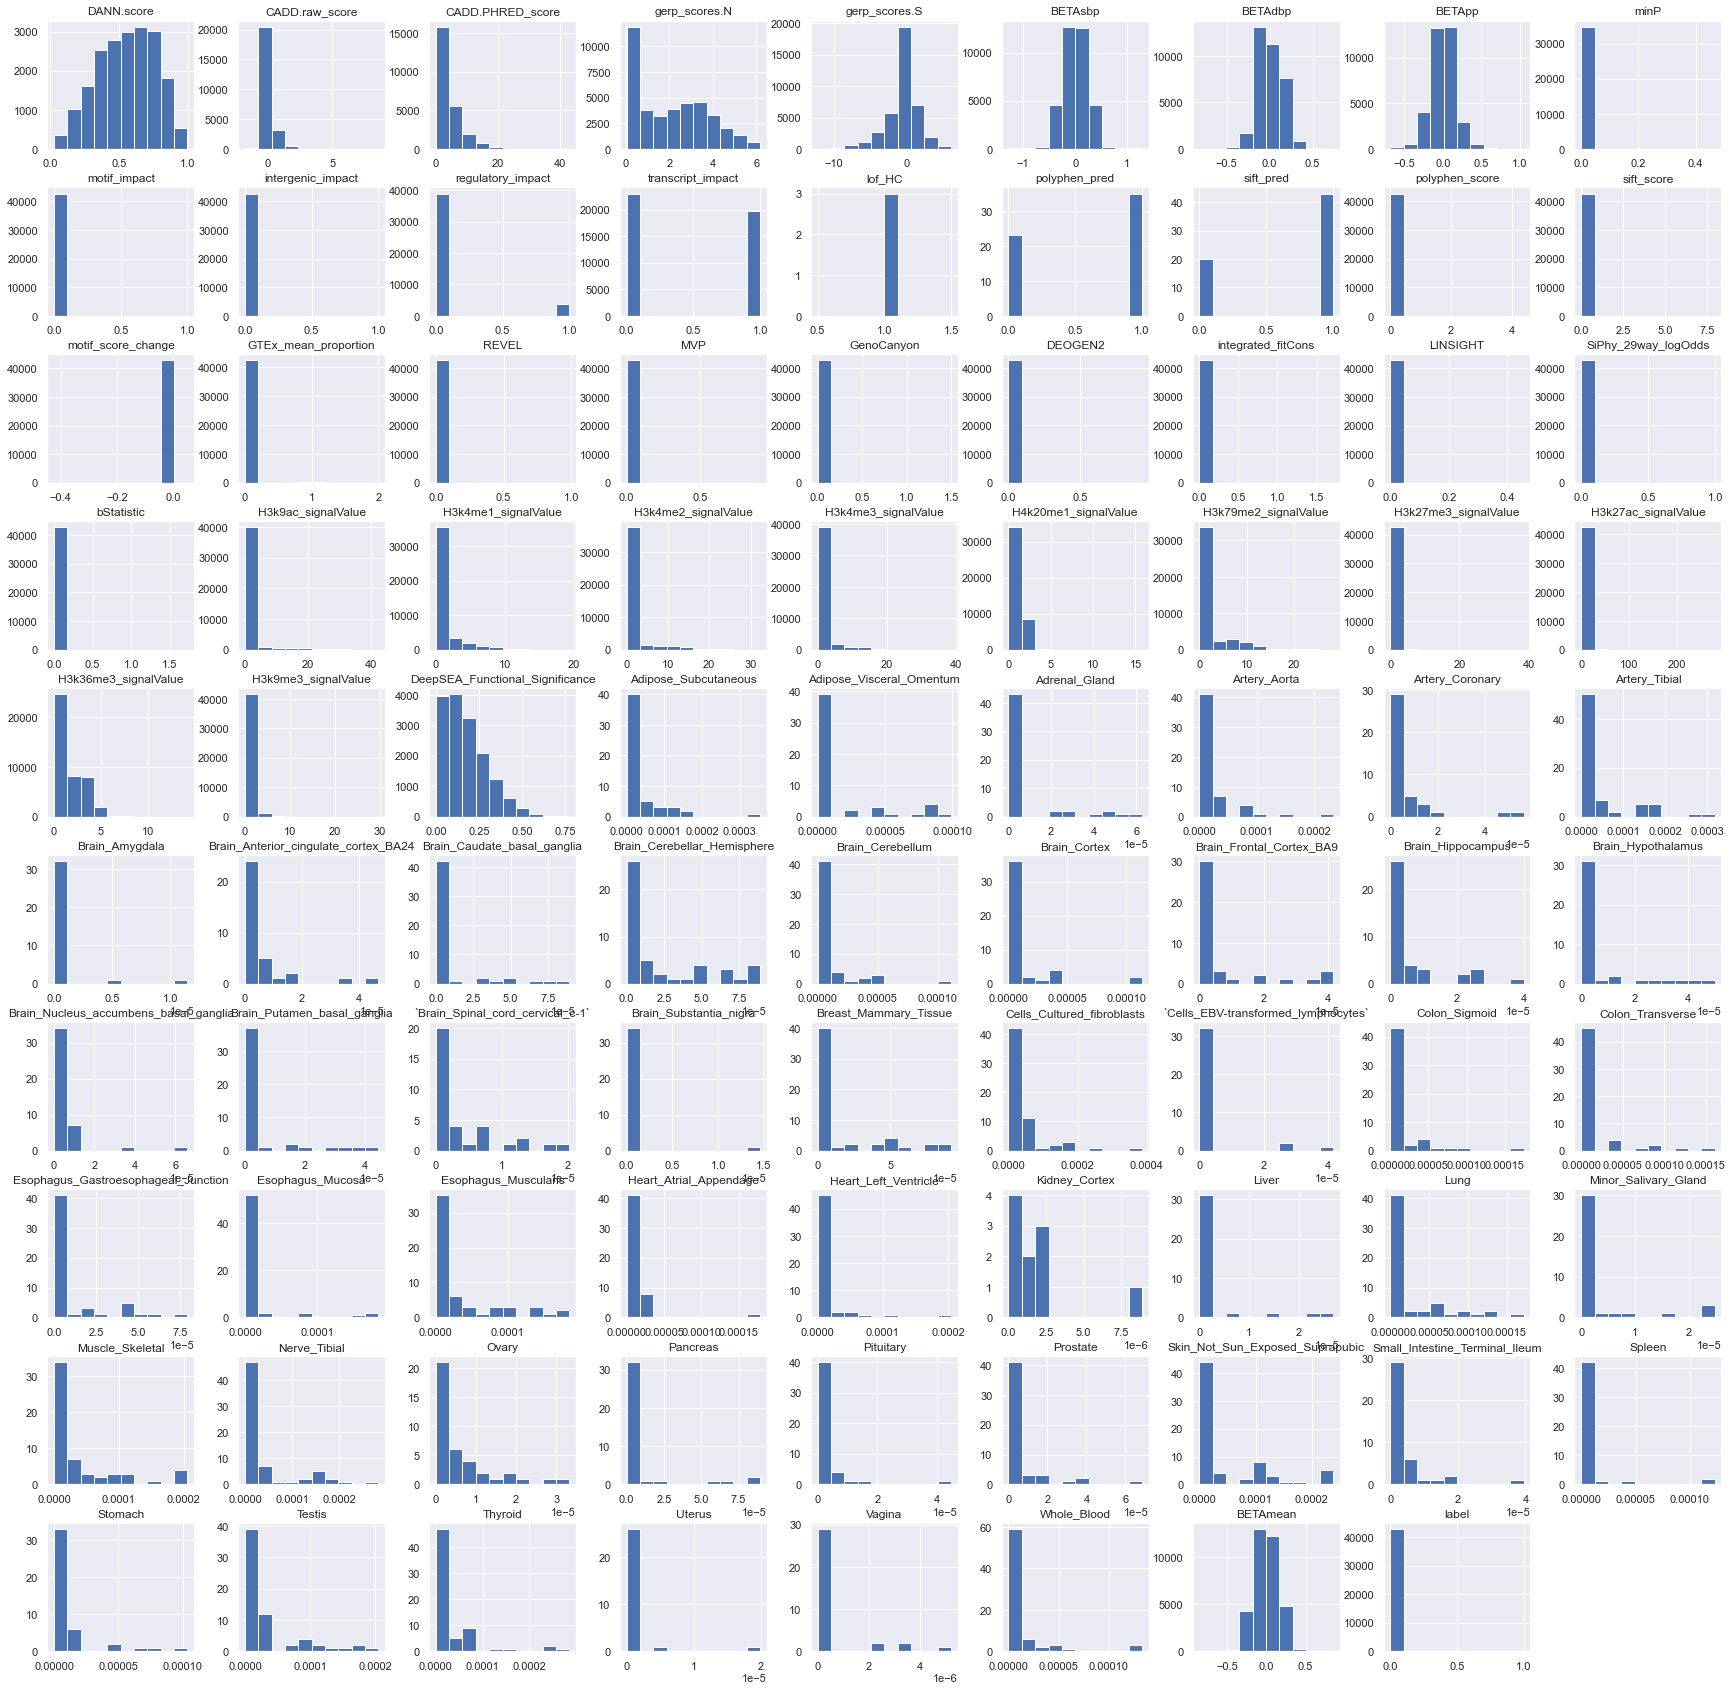

In [6]:
# Attempting to plot distributions of all variables, but I haven't been able to resize the text
sns.set(style="darkgrid")
features.hist(figsize=(30, 30))

# Exploring annotation missingness with missingno package

In [7]:
features = features.replace({0: pd.NA})

<AxesSubplot:>

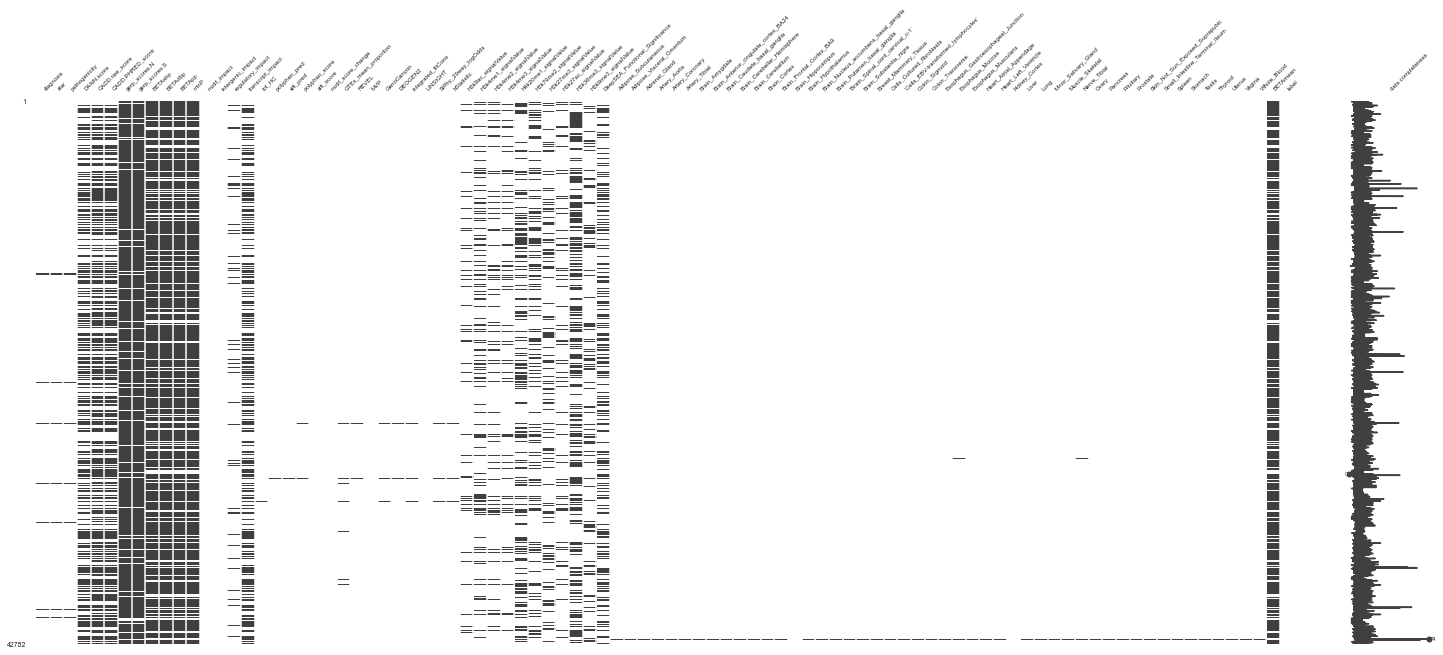

In [8]:
# Using the missingno packaging to explore missingness in the data - although this dataset is also too larger here to space it well in the notebook
# Any feature in only white is heavily missing
msno.matrix(features, labels=True, fontsize=6)

<AxesSubplot:>

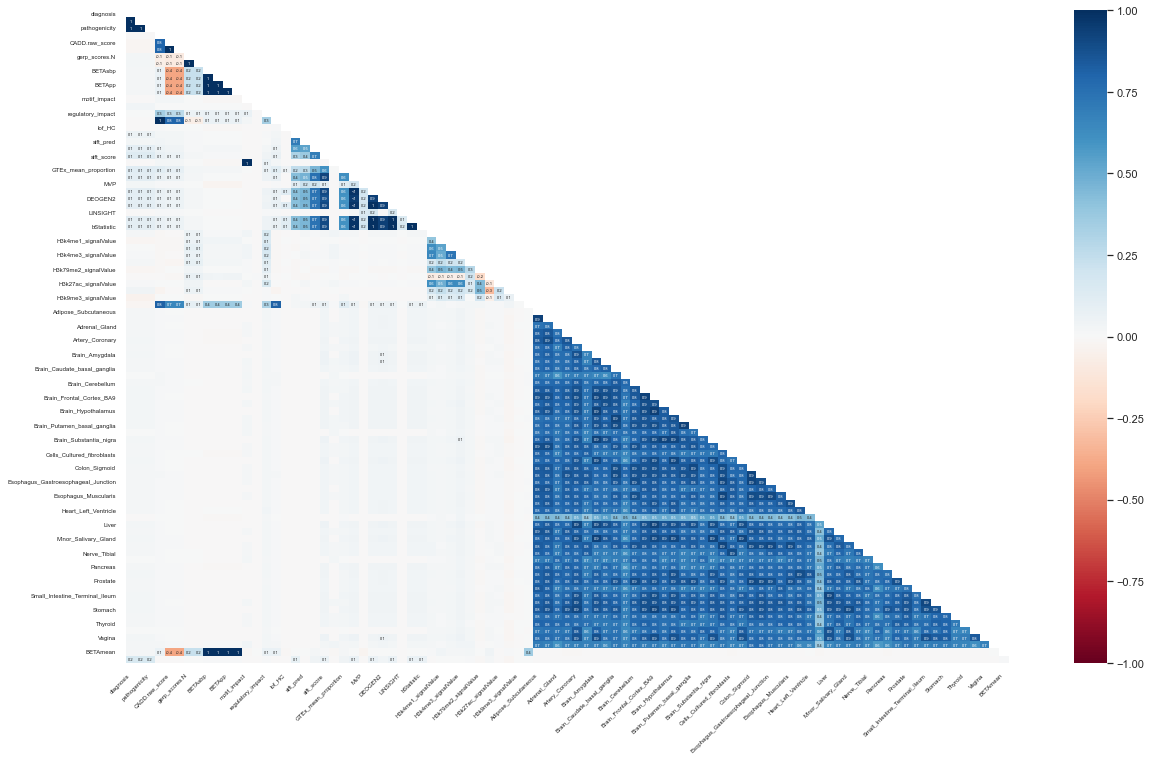

In [9]:
# Exploring how feature's missingness relates to each other - more positive values indicate that if one variable appears the other definitely also does
# Variables that are always full or always empty have no meaningful correlation
msno.heatmap(features, fontsize=6)

<AxesSubplot:>

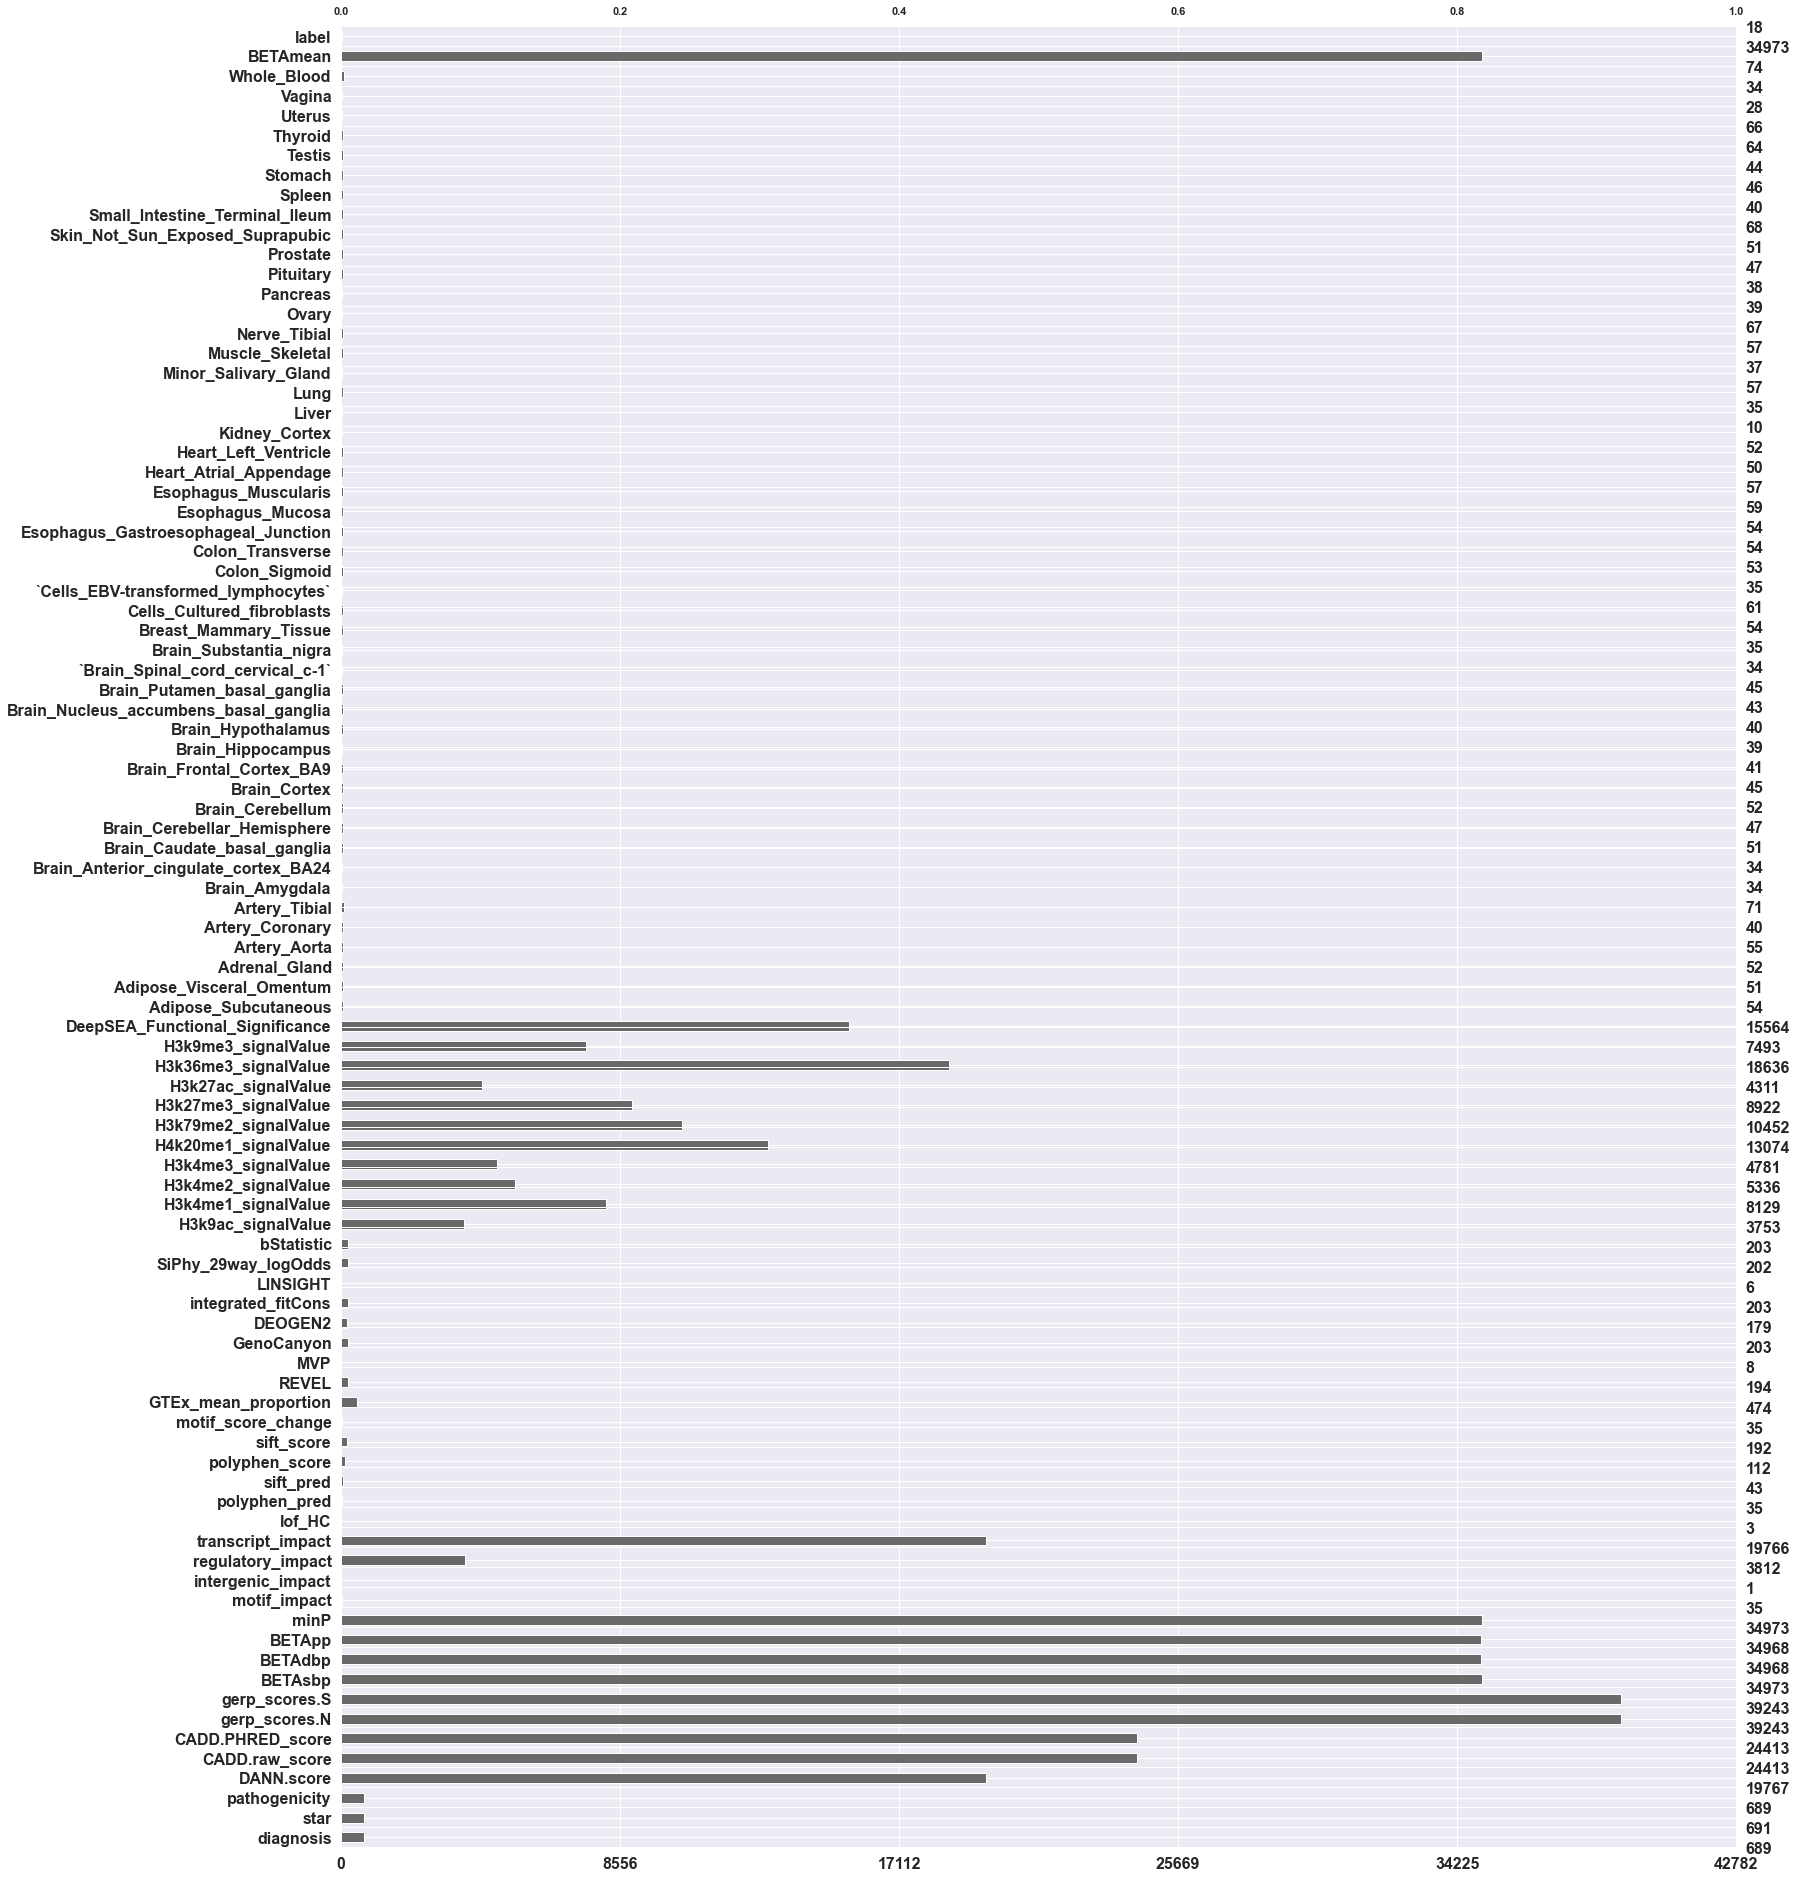

In [12]:
# Viewing overall missingness - having trouble with the axes on this one
# I think the Y axis on the right is number of rows with data, and the x axis is the variants row numbers but I think it looks more confusing than helpful
plt.rcParams["font.weight"] = "bold"
plt.rcParams["axes.labelweight"] = "bold"
msno.bar(features)

<BarContainer object of 92 artists>

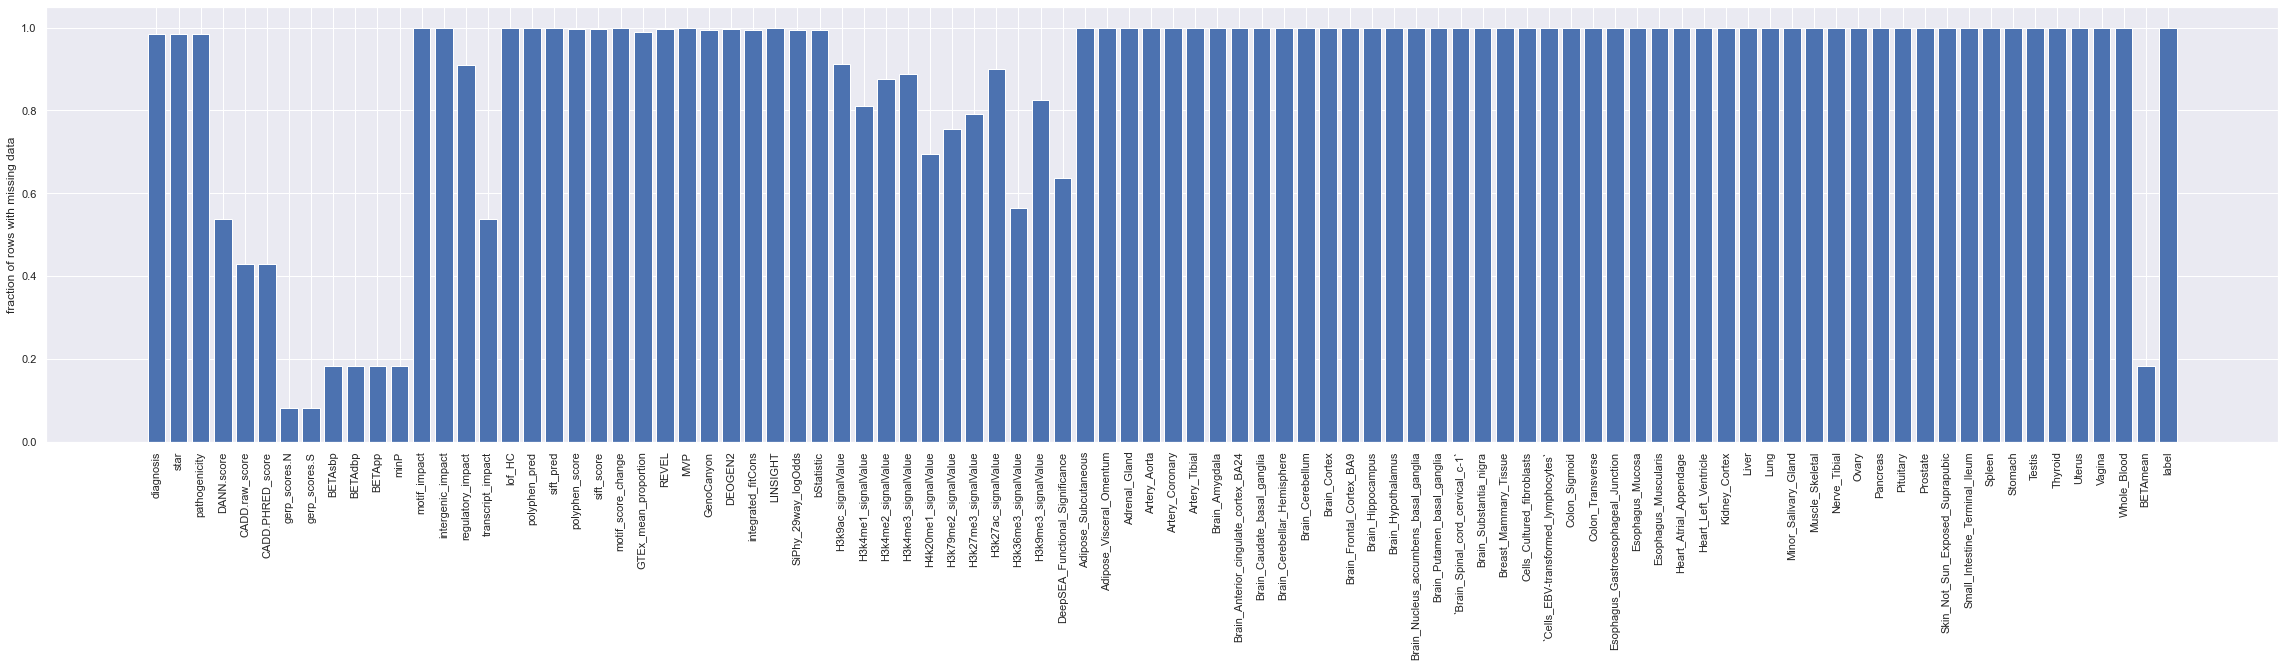

In [12]:
# Viewing overall missingness - trying a more manual version where taller bars equal higher missingess
data = features
natest = data.isnull().sum()
natest.sort_values(inplace=True)

percent_missing = data.isnull().sum() * 100 / len(data)
missing_value_df = pd.DataFrame(
    {"column_name": data.columns, "percent_missing": percent_missing}
)
missing_value_df.sort_values("percent_missing", inplace=True)

natest = natest.to_frame()
missingdata = natest.join(missing_value_df)

null_counts = data.isnull().sum() / len(data)
plt.figure(figsize=(40, 8))
plt.xticks(
    np.arange(len(null_counts)) + 0.0, null_counts.index, rotation="vertical"
)  # when I rtry rotation=45 the text all overlaps
plt.ylabel("fraction of rows with missing data")
plt.bar(np.arange(len(null_counts)), null_counts)

# Visualising relationships between positive and 'negative' variants for each annotation

In [16]:
positives = pd_table.loc[pd_table["label"] == 1]
negatives = pd_table.loc[pd_table["label"] == 0]
#negatives = negatives.iloc[0:18,]
pos_neg_dt = positives.append(negatives)

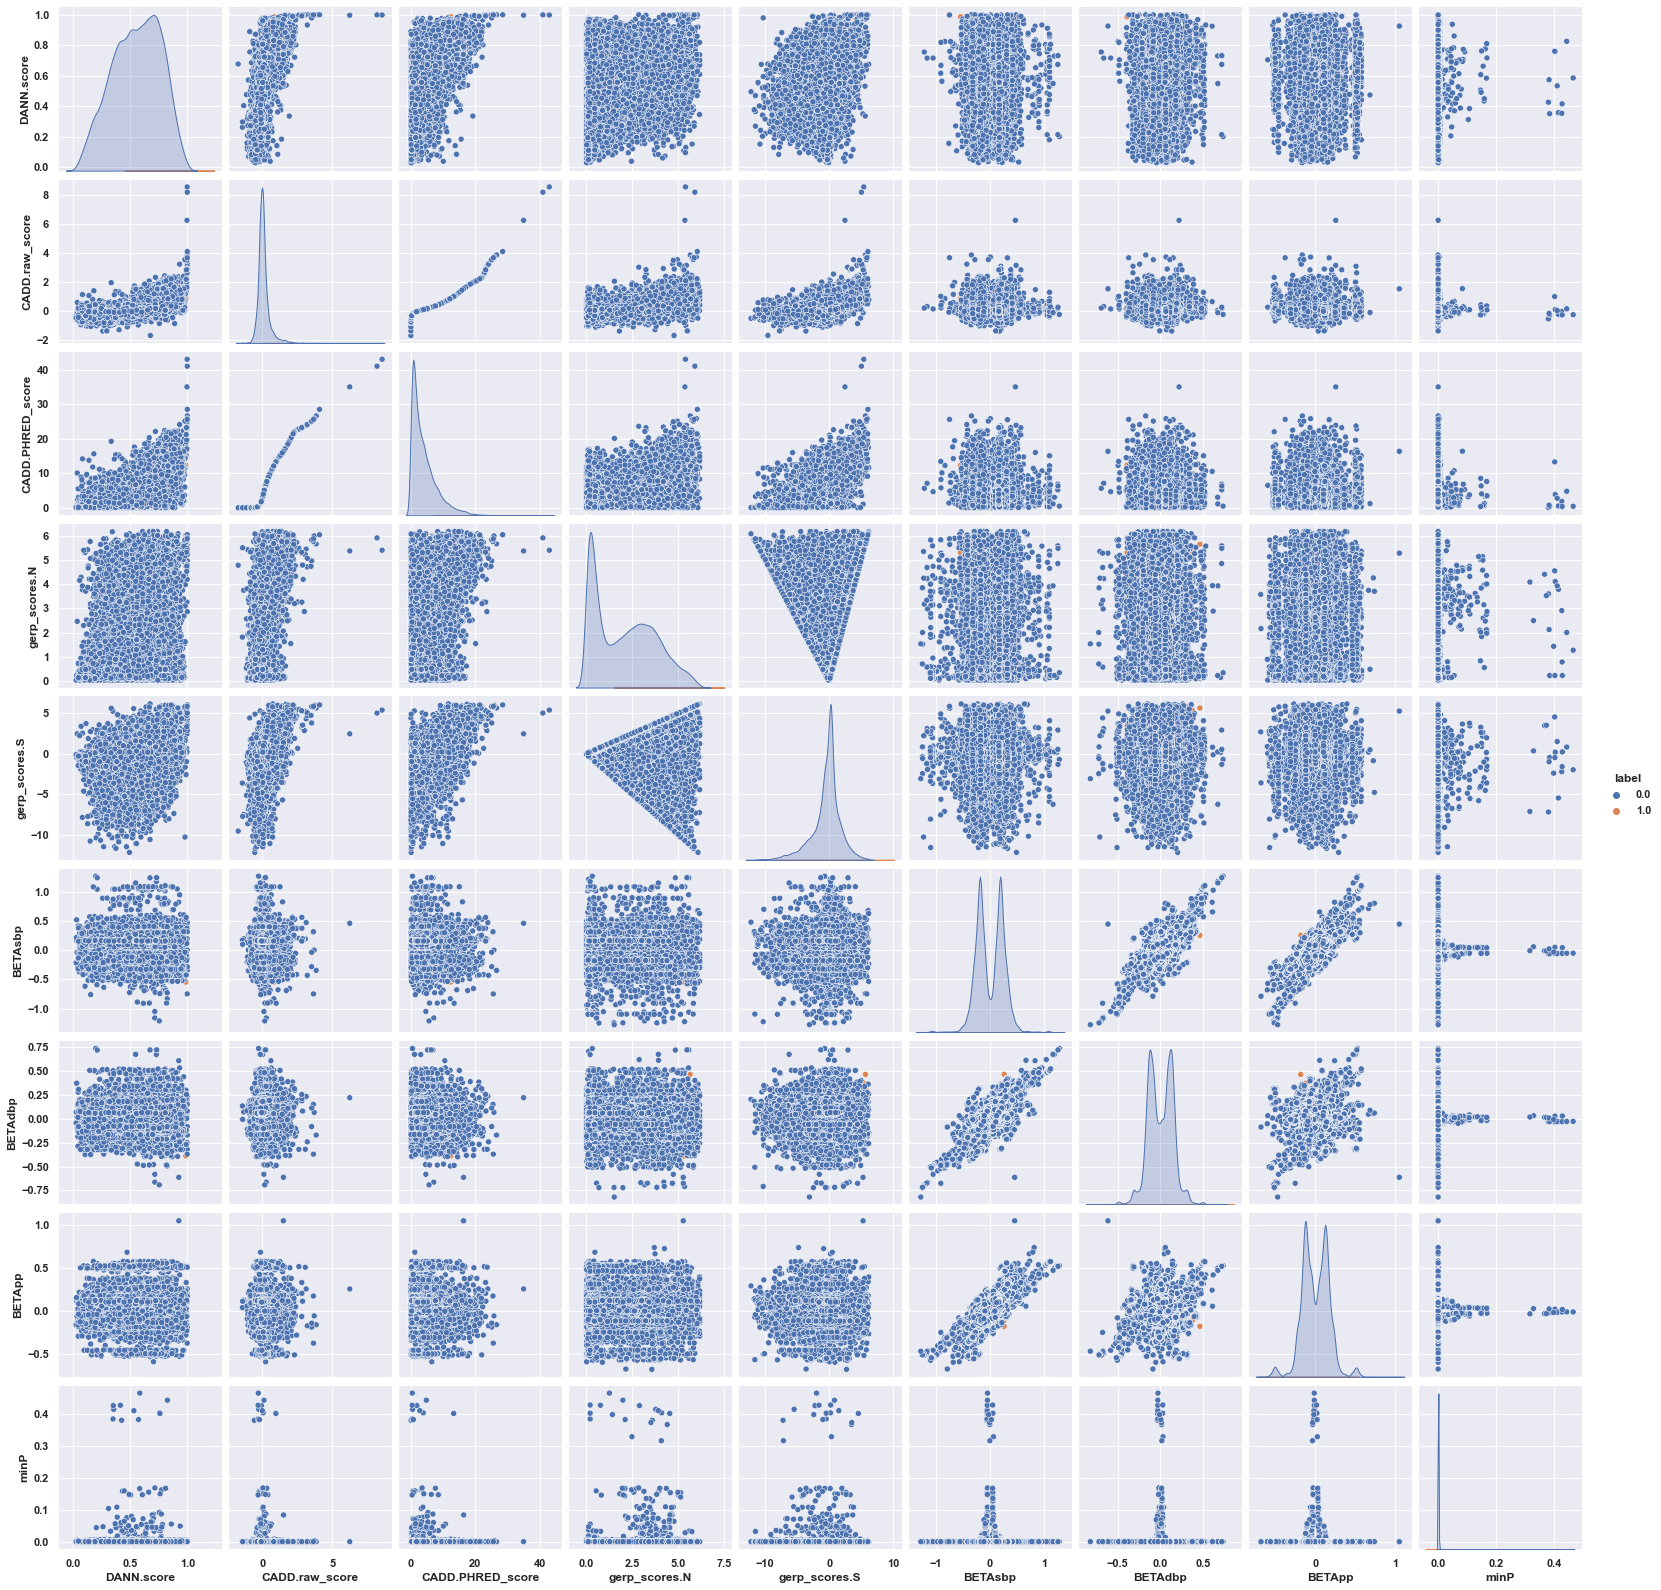

In [17]:
# Viewing pair-wise plots for the most complete/least missing features
sns.set(font_scale=1)
plt.rcParams["font.weight"] = "bold"
plt.rcParams["axes.labelweight"] = "bold"
features2 = pos_neg_dt[
    [
        "label",
        "DANN.score",
        "CADD.raw_score",
        "CADD.PHRED_score",
        "gerp_scores.N",
        "gerp_scores.S",
        "BETAsbp",
        'BETAdbp',
        'BETApp',
        "minP",
    ]
]
sns.pairplot(features2, hue="label")

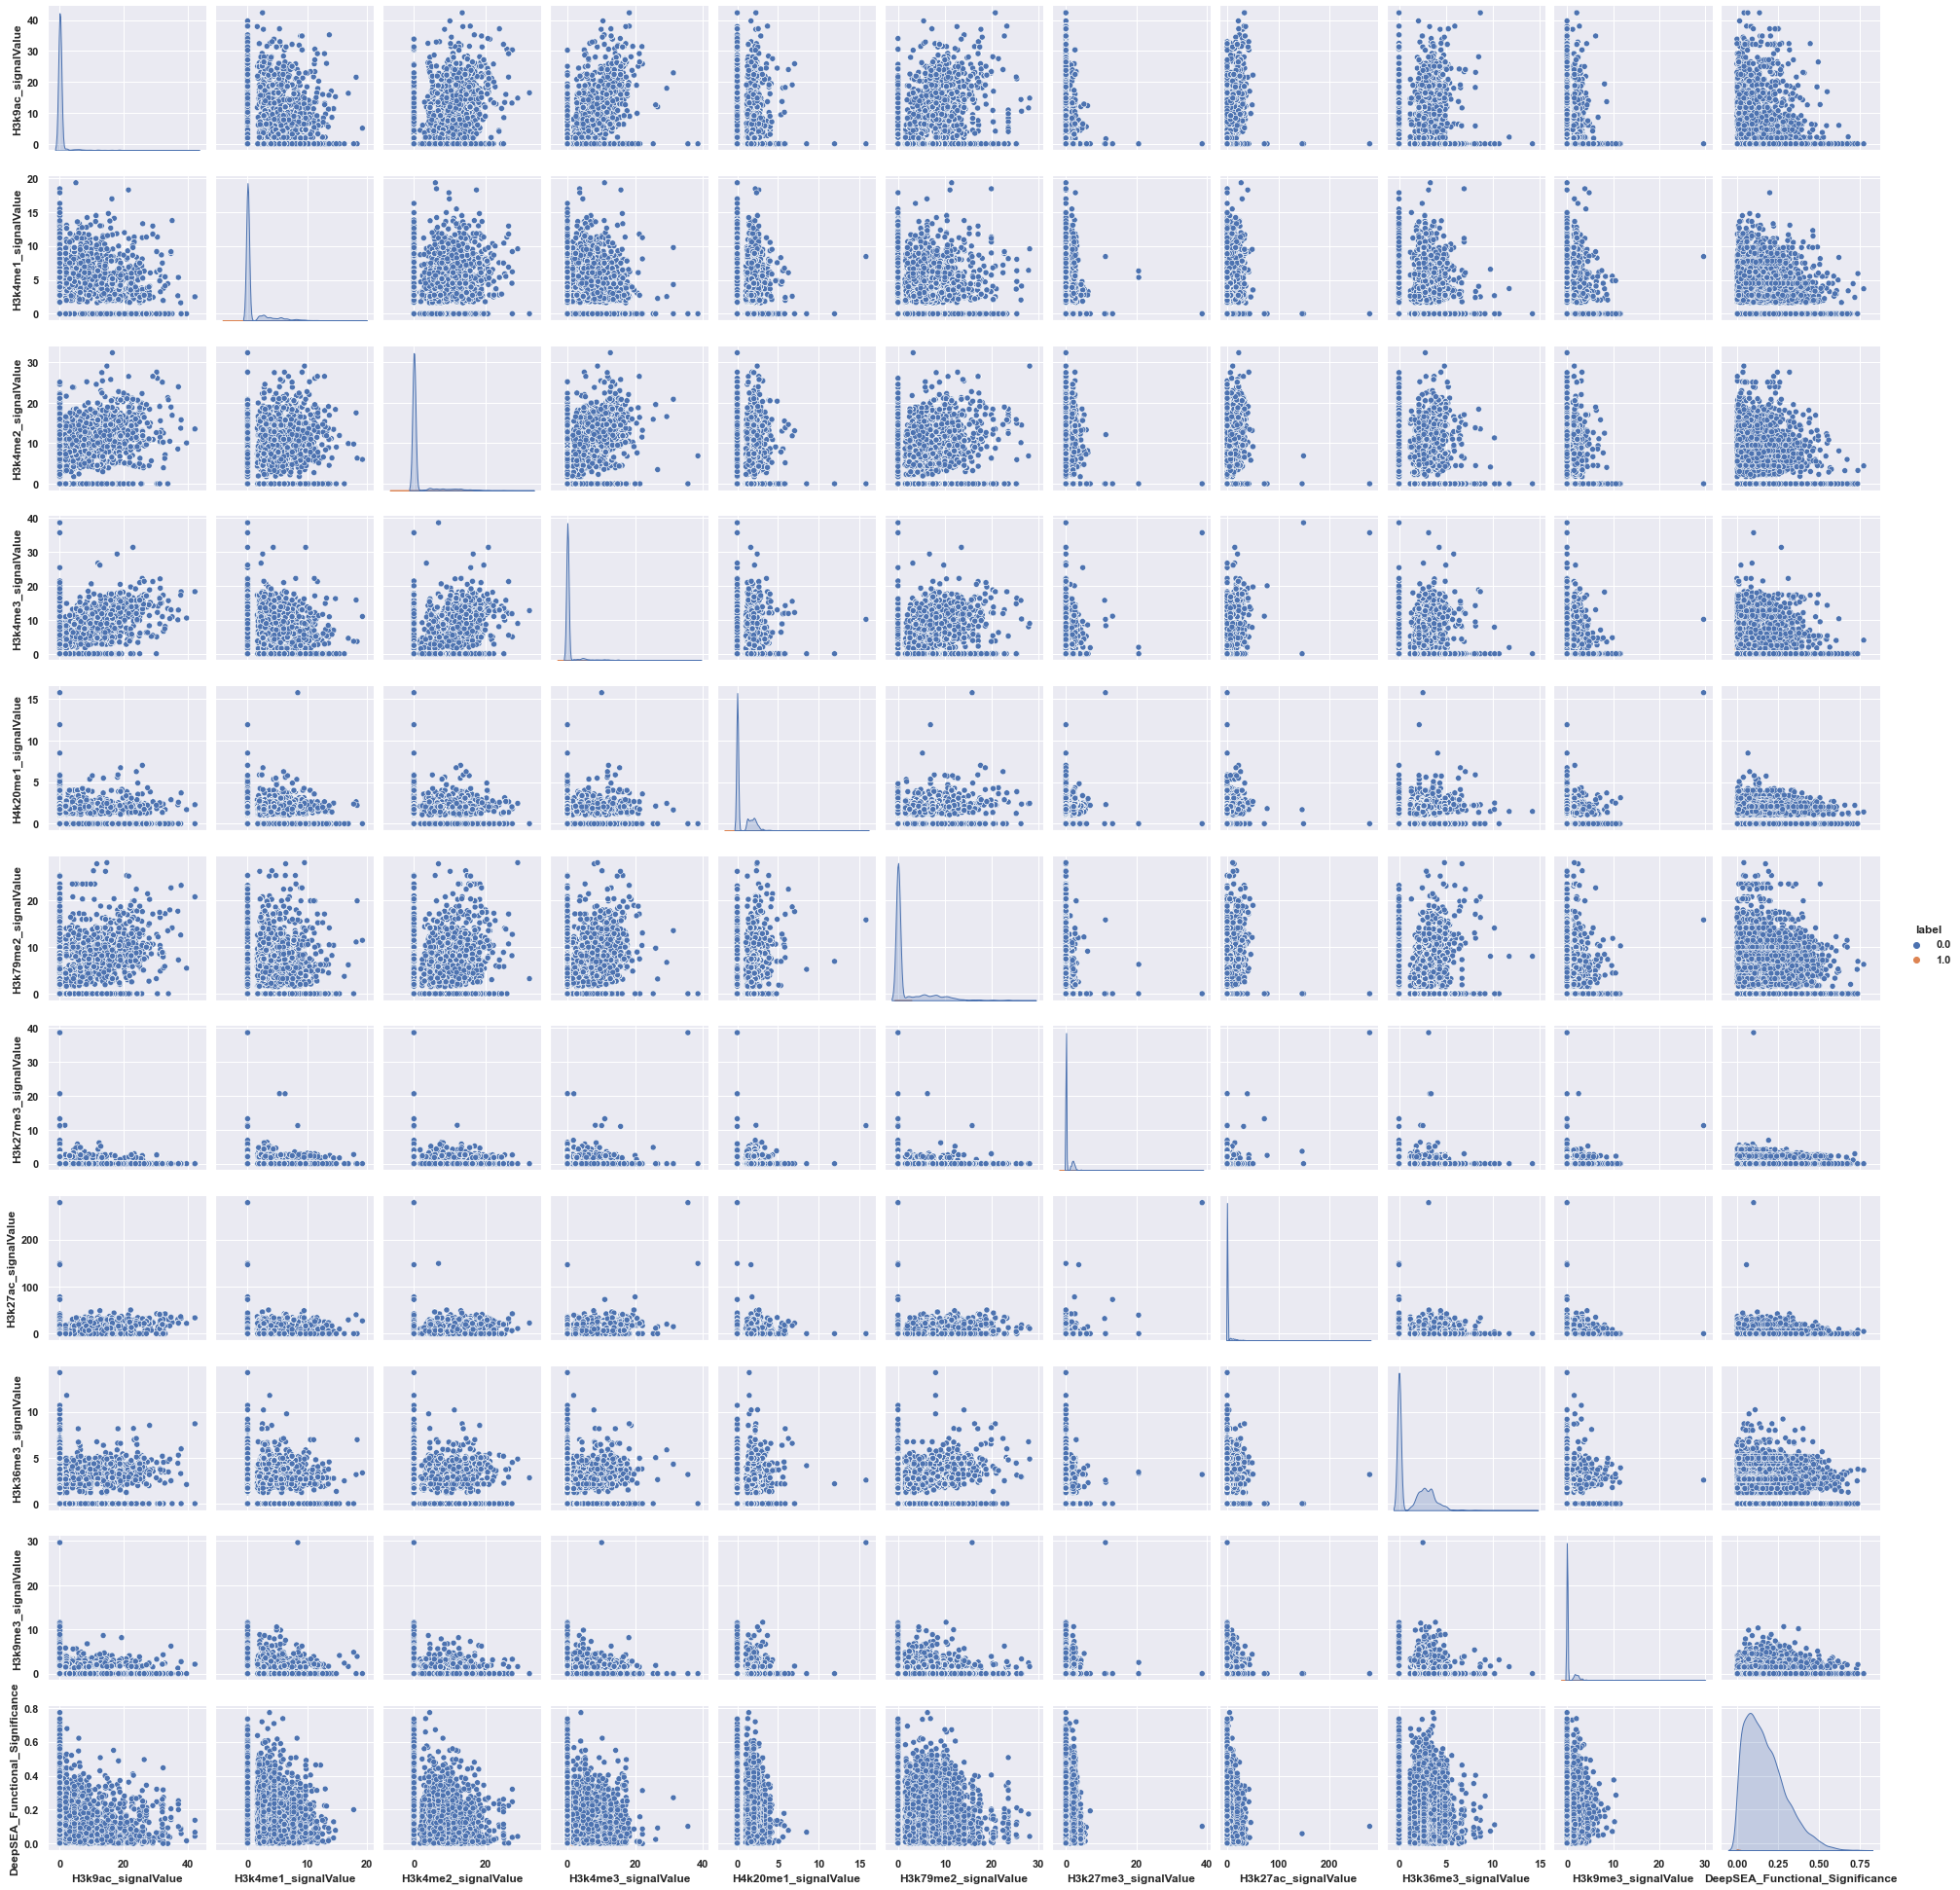

In [18]:
# Viewing pair-wise plots for the most complete/least missing features
sns.set(font_scale=1)
plt.rcParams["font.weight"] = "bold"
plt.rcParams["axes.labelweight"] = "bold"
features2 = pos_neg_dt[
    [
        "label",
      'H3k9ac_signalValue',
 'H3k4me1_signalValue',
 'H3k4me2_signalValue',
 'H3k4me3_signalValue',
 'H4k20me1_signalValue',
 'H3k79me2_signalValue',
 'H3k27me3_signalValue',
 'H3k27ac_signalValue',
 'H3k36me3_signalValue',
 'H3k9me3_signalValue',
 'DeepSEA_Functional_Significance',
    ]
]
sns.pairplot(features2, hue="label")

In [13]:
positives = pd_table.loc[pd_table["label"] == 1]
negatives = pd_table.loc[pd_table["label"] == 0]
negatives = negatives.iloc[0:18,]
pos_neg_dt = positives.append(negatives)

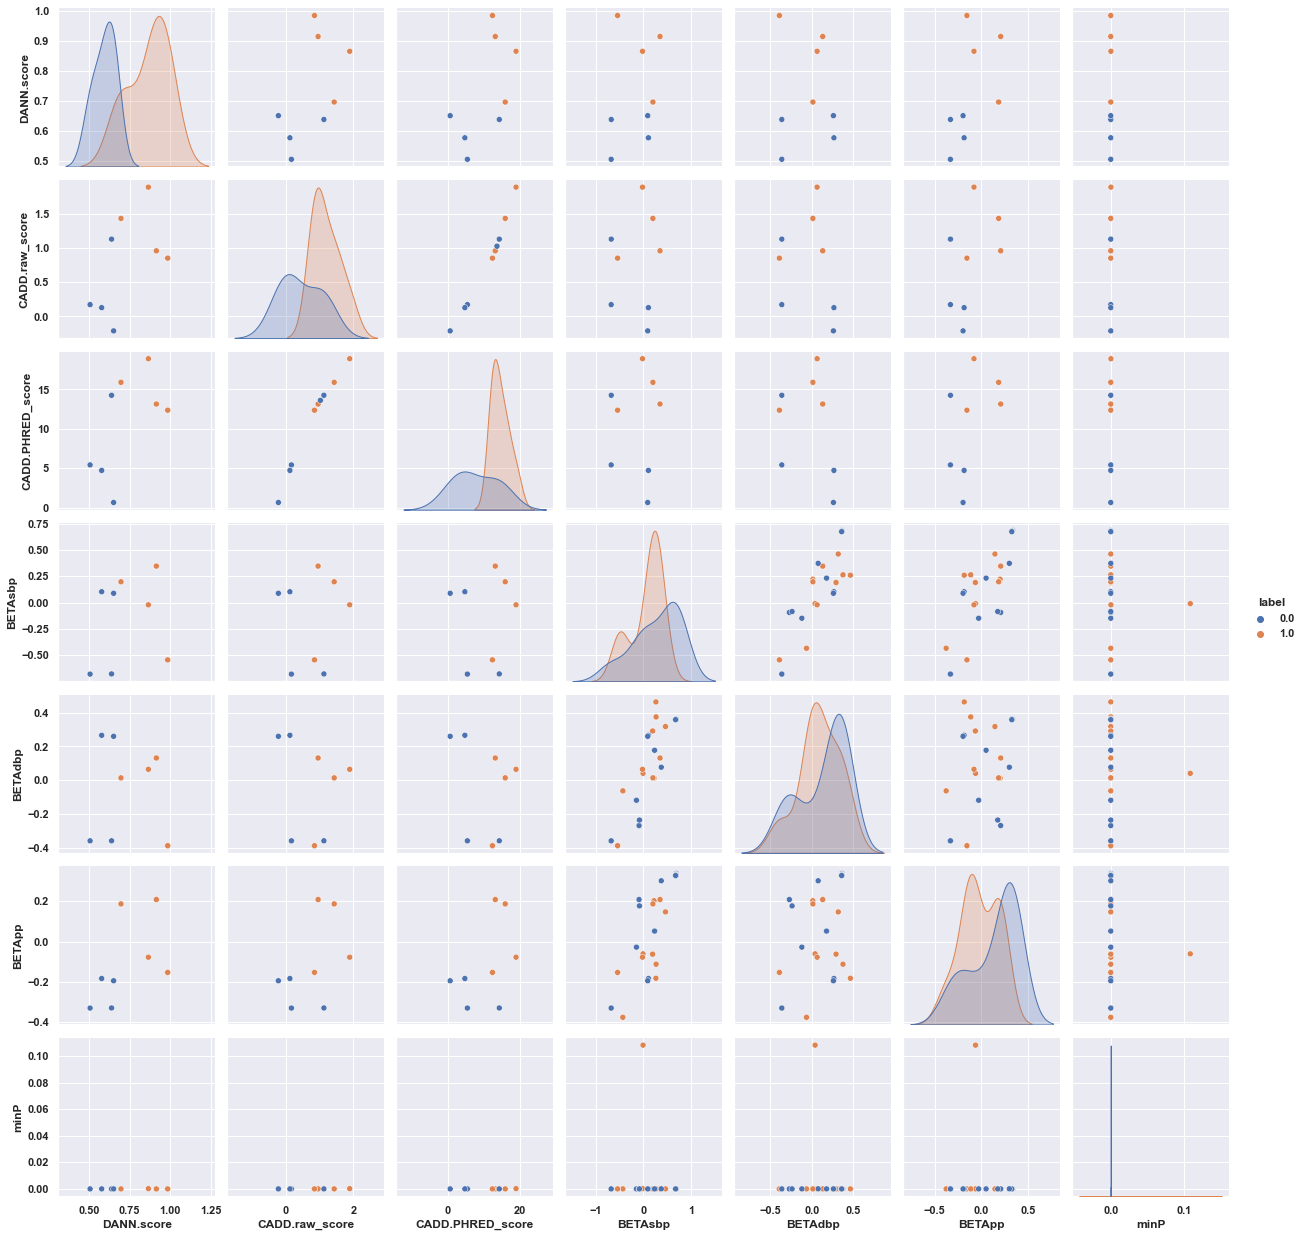

In [14]:
sns.set(font_scale=1)
plt.rcParams["font.weight"] = "bold"
plt.rcParams["axes.labelweight"] = "bold"
features2 = pos_neg_dt[
    [
        "label",
        "DANN.score",
        "CADD.raw_score",
        "CADD.PHRED_score",
        "BETAsbp",
        'BETAdbp',
        'BETApp',
        "minP",
    ]
]
sns.pairplot(features2, hue="label")

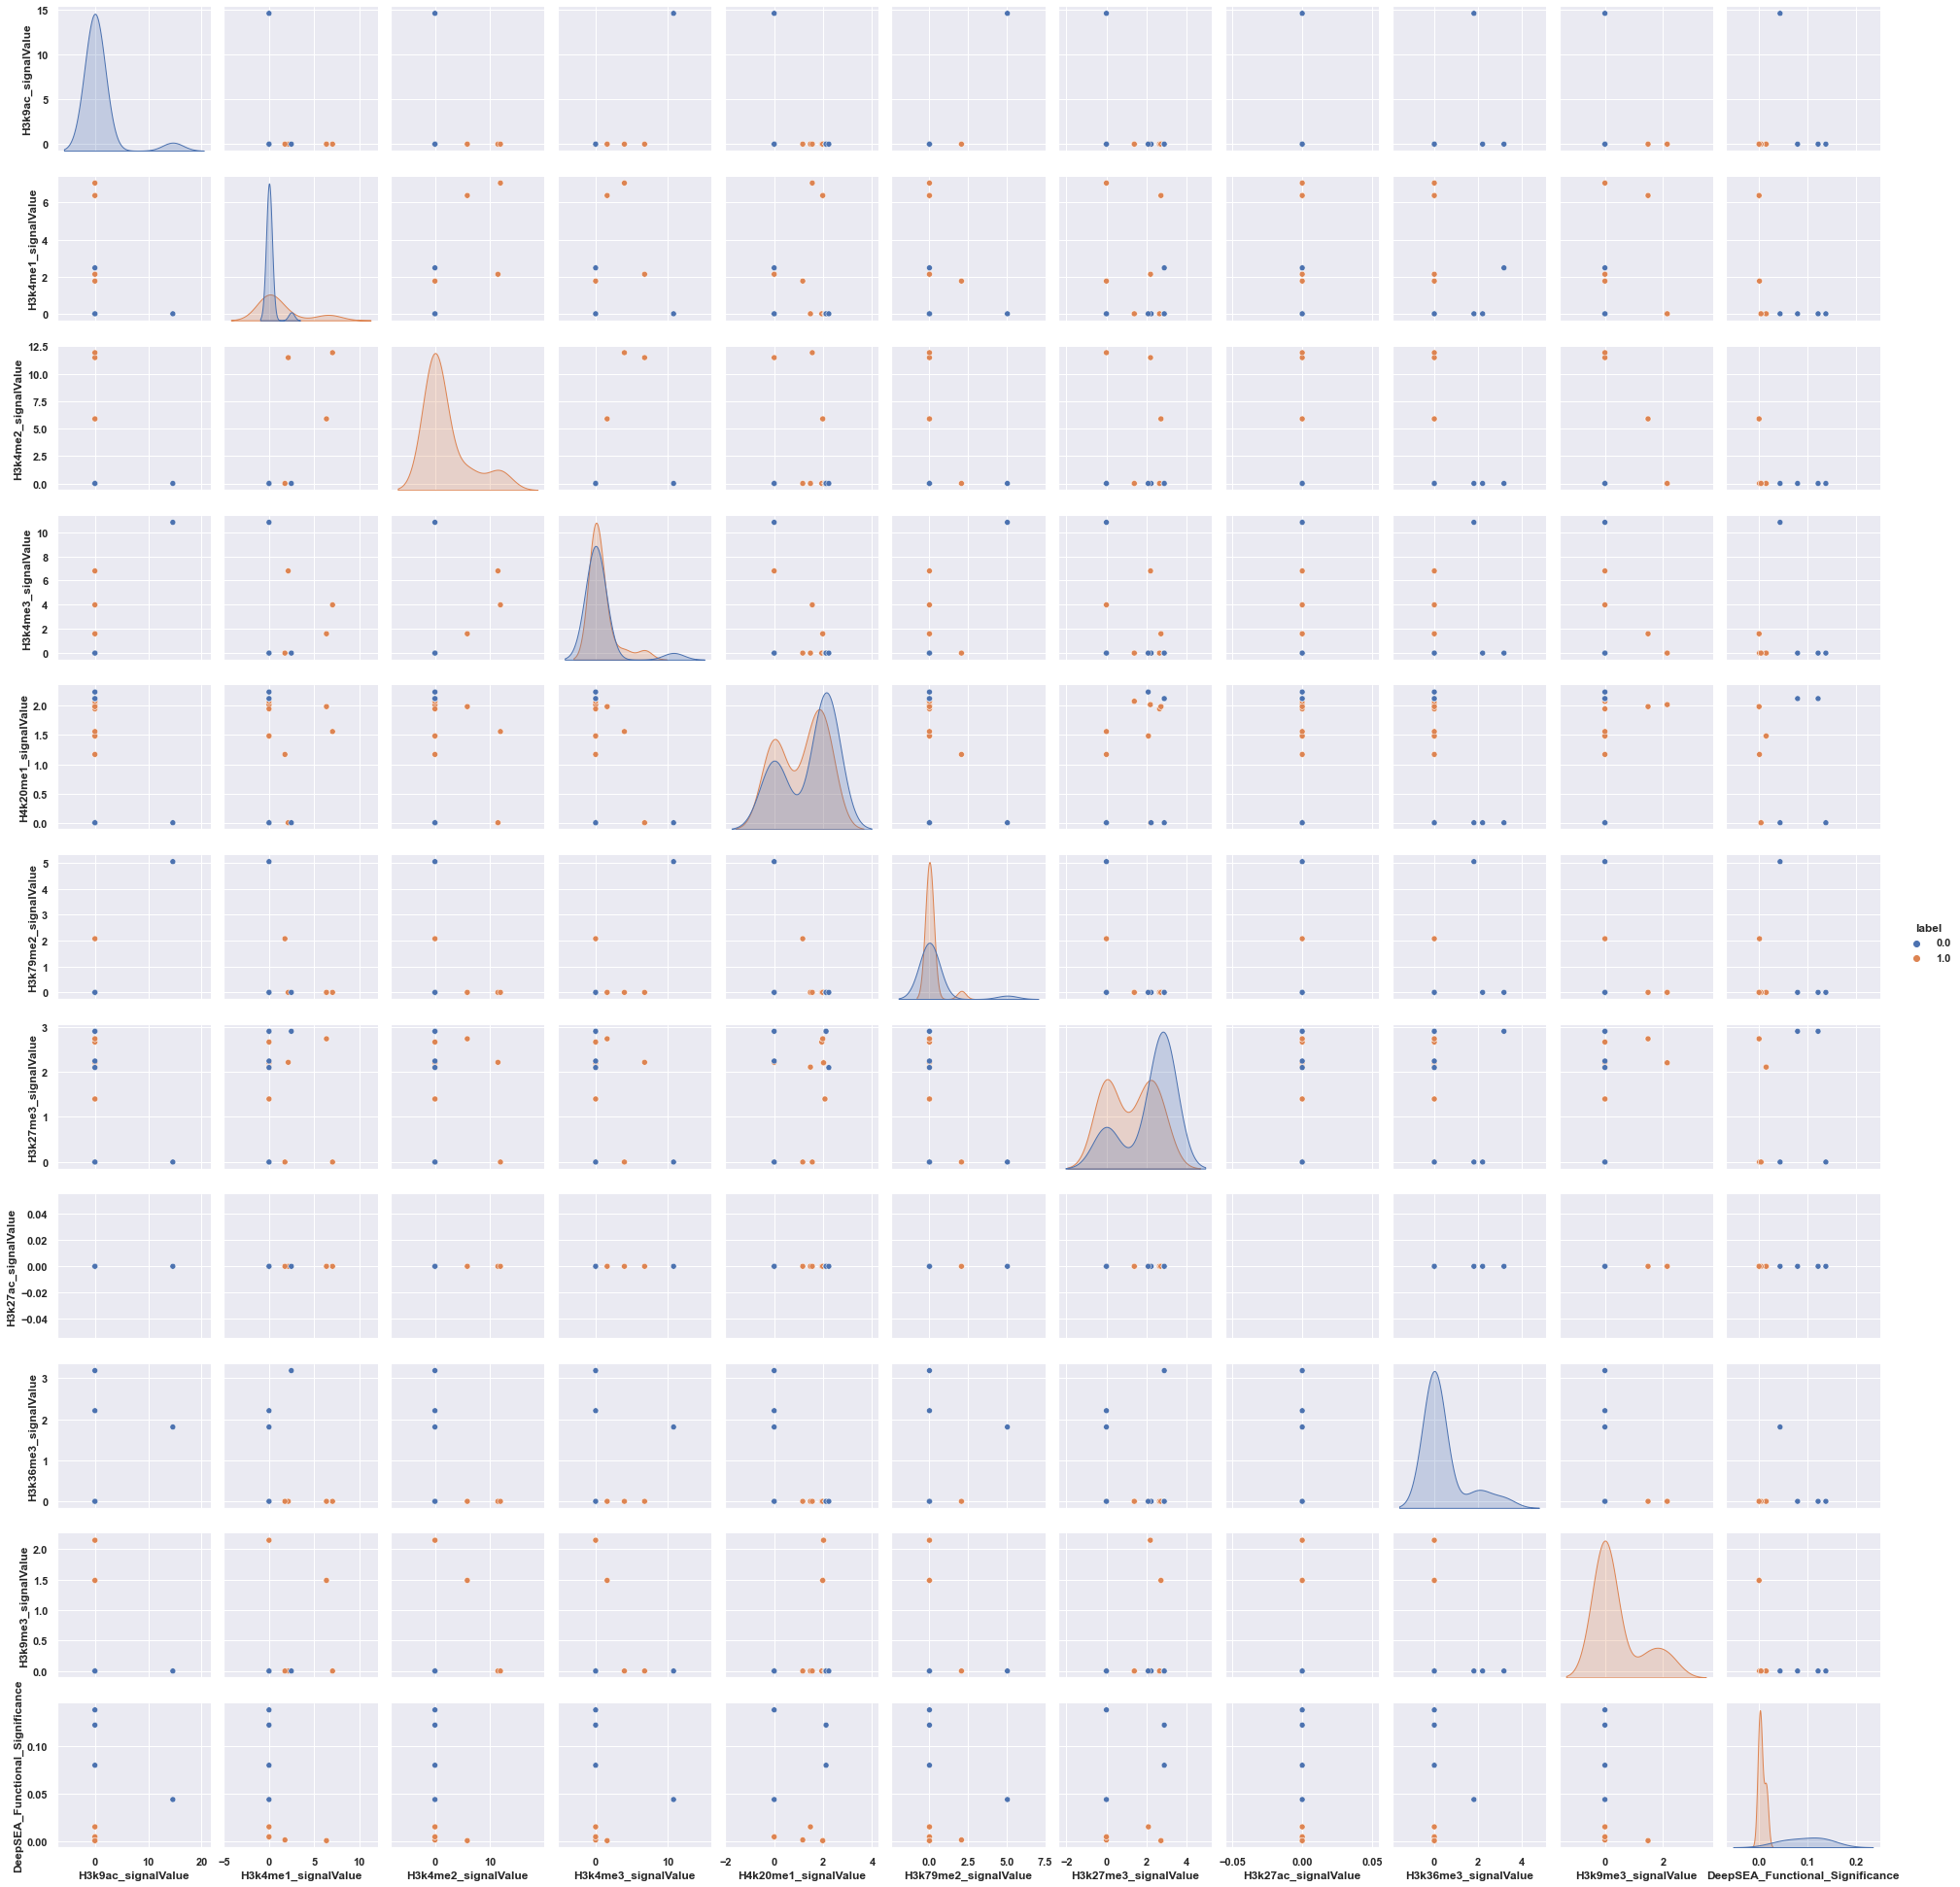

In [21]:
# Viewing pair-wise plots for the most complete/least missing features
sns.set(font_scale=1)
plt.rcParams["font.weight"] = "bold"
plt.rcParams["axes.labelweight"] = "bold"
features2 = pos_neg_dt[
    [
        "label",
      'H3k9ac_signalValue',
 'H3k4me1_signalValue',
 'H3k4me2_signalValue',
 'H3k4me3_signalValue',
 'H4k20me1_signalValue',
 'H3k79me2_signalValue',
 'H3k27me3_signalValue',
 'H3k27ac_signalValue',
 'H3k36me3_signalValue',
 'H3k9me3_signalValue',
 'DeepSEA_Functional_Significance',
    ]
]
sns.pairplot(features2, hue="label")

# Visualising correlated features

In [22]:
features = pd_table.drop(["Gene", "CP"], axis=1)
features["label"] = np.where(pd_table["label"] == True, 1, 0)
correlated_features = set()
correlation_matrix = features.corr()


for i in range(len(correlation_matrix.columns)):
    for j in range(i):
        if abs(correlation_matrix.iloc[i, j]) > 0.9:
            colname = correlation_matrix.columns[i]
            correlated_features.add(colname)

In [23]:
print(correlated_features)

{'Minor_Salivary_Gland', 'Brain_Caudate_basal_ganglia', 'Uterus', 'BETAmean', 'Brain_Anterior_cingulate_cortex_BA24', 'CADD.PHRED_score', 'Pituitary', 'Brain_Substantia_nigra', 'Kidney_Cortex'}


label                 1.000000
polyphen_pred         0.153197
polyphen_score        0.146962
REVEL                 0.099640
integrated_fitCons    0.067565
                        ...   
Testis                     NaN
Thyroid                    NaN
Uterus                     NaN
Vagina                     NaN
Whole_Blood                NaN
Name: label, Length: 88, dtype: float64


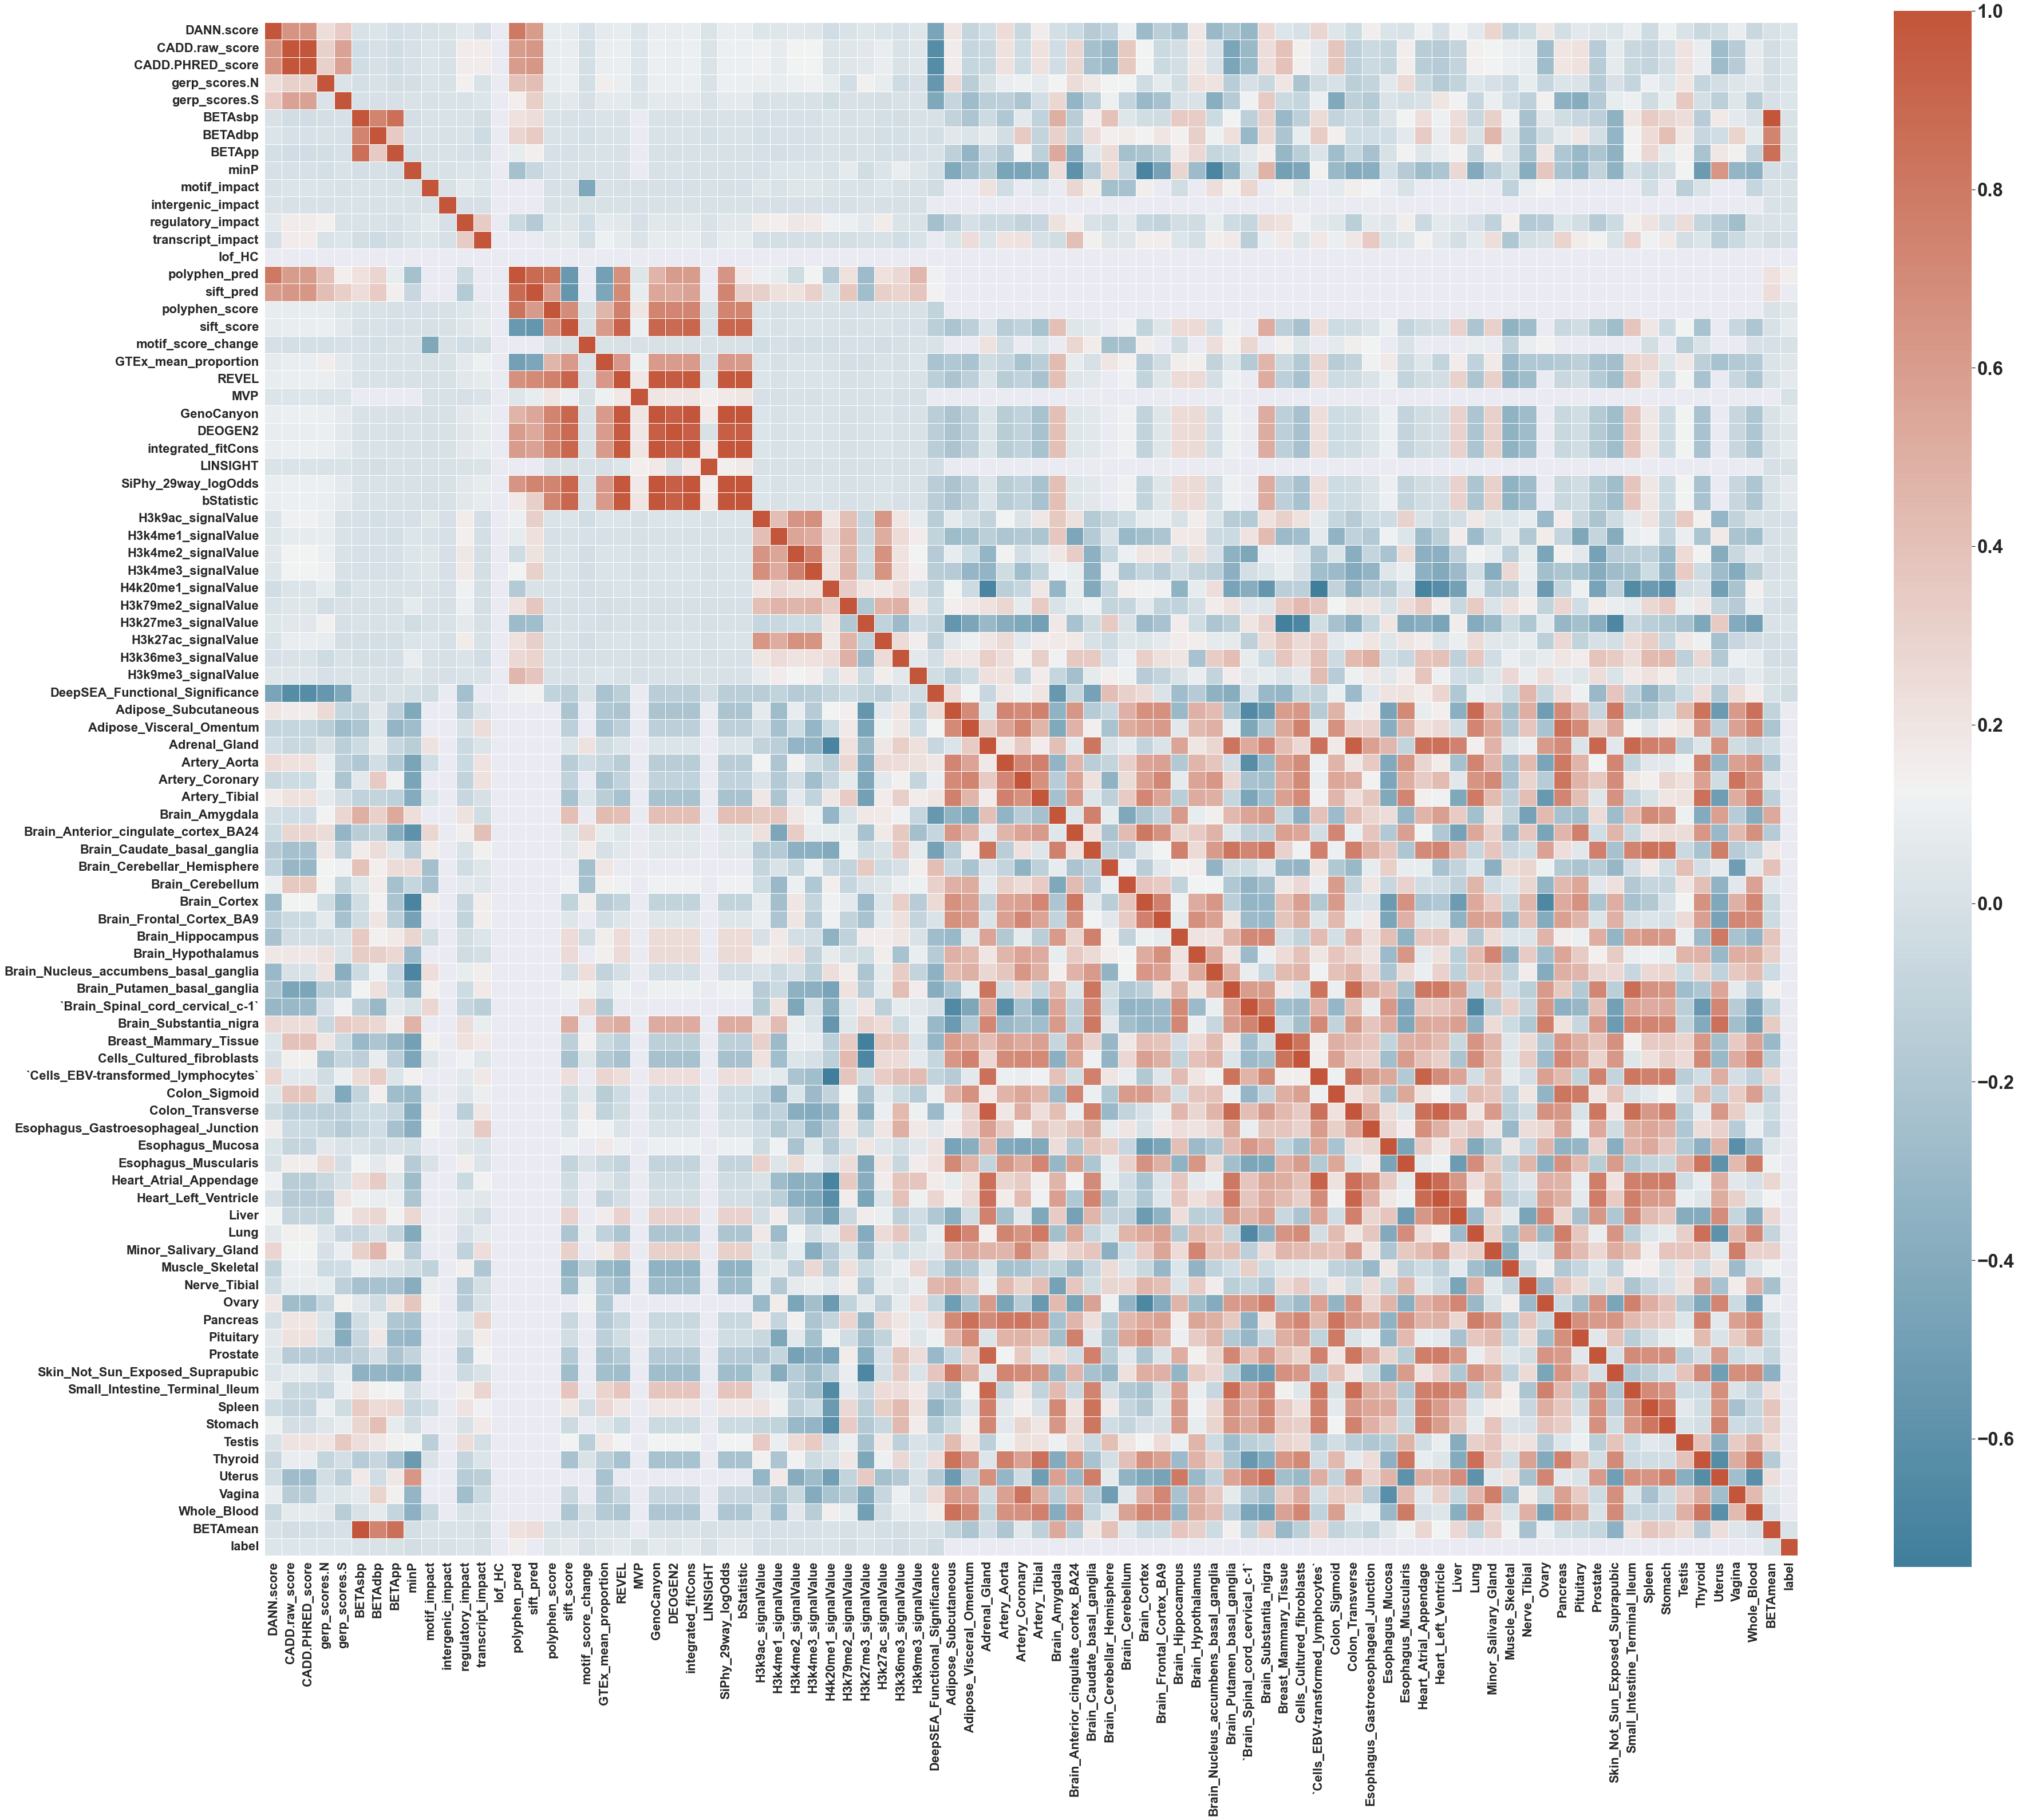

In [46]:
corr = features.corr(method="spearman")

f, ax = plt.subplots(figsize=(60, 50))

cmap = sns.diverging_palette(230, 20, as_cmap=True)

sns.set(font_scale=3)
sns.heatmap(
    corr,
    cmap=cmap,
    square=True,
    xticklabels=True,
    yticklabels=True,
    linewidths=0.5,
    ax=ax,
)

corr_matrix = features.corr()
print(corr_matrix["label"].sort_values(ascending=False))
corr = corr_matrix["label"].sort_values(ascending=False)

In [25]:
corr_matrix .to_csv("corr09_matrix.csv", header=True)

In [26]:
def corrFilter(x: pd.DataFrame, bound: float):
    xCorr = x.corr()
    xFiltered = xCorr[((xCorr >= bound) | (xCorr <= -bound)) & (xCorr !=1.000)]
    xFlattened = xFiltered.unstack().sort_values().drop_duplicates()
    return xFlattened

corrFilter(features, .9)

BETAdbp                               Kidney_Cortex                         -0.915379
BETAmean                              Kidney_Cortex                         -0.913790
BETAsbp                               Kidney_Cortex                         -0.913672
BETApp                                Kidney_Cortex                         -0.912346
Kidney_Cortex                         `Cells_EBV-transformed_lymphocytes`    0.904041
                                      Artery_Coronary                        0.908232
Uterus                                Minor_Salivary_Gland                   0.914952
Brain_Caudate_basal_ganglia           Uterus                                 0.943585
                                      Kidney_Cortex                          0.944485
Pituitary                             Kidney_Cortex                          0.944485
Brain_Cortex                          Kidney_Cortex                          0.944485
Brain_Anterior_cingulate_cortex_BA24  Brain_Amygdala  

In [27]:
corrFilter(features, .9).to_csv("corr09_pairs.csv", header=True)

In [28]:
features = pd_table.drop(["Gene", "CP", "label", 'Kidney_Cortex'], axis=1)
features["label"] = np.where(pd_table["label"] == True, 1, 0)
correlated_features = set()
correlation_matrix = features.corr()


for i in range(len(correlation_matrix.columns)):
    for j in range(i):
        if abs(correlation_matrix.iloc[i, j]) > 0.8:
            colname = correlation_matrix.columns[i]
            correlated_features.add(colname)

In [29]:
print(correlated_features)

{'Minor_Salivary_Gland', 'sift_pred', 'Brain_Caudate_basal_ganglia', 'Uterus', 'bStatistic', 'Brain_Anterior_cingulate_cortex_BA24', 'BETAmean', 'SiPhy_29way_logOdds', 'Vagina', 'integrated_fitCons', 'Heart_Atrial_Appendage', 'Pituitary', 'BETApp', 'Brain_Substantia_nigra', 'CADD.PHRED_score'}


In [30]:
def corrFilter(x: pd.DataFrame, bound: float):
    xCorr = x.corr()
    xFiltered = xCorr[((xCorr >= bound) | (xCorr <= -bound)) & (xCorr !=1.000)]
    xFlattened = xFiltered.unstack().sort_values().drop_duplicates()
    return xFlattened

corrFilter(features, .8)

integrated_fitCons           GenoCanyon                              0.802523
bStatistic                   GenoCanyon                              0.821175
Pituitary                    Brain_Anterior_cingulate_cortex_BA24    0.826414
SiPhy_29way_logOdds          REVEL                                   0.826975
BETAmean                     BETApp                                  0.828103
BETApp                       BETAsbp                                 0.829827
Heart_Atrial_Appendage       Brain_Anterior_cingulate_cortex_BA24    0.830723
minP                         Vagina                                  0.844691
Heart_Left_Ventricle         Uterus                                  0.855173
polyphen_pred                sift_pred                               0.875021
Uterus                       Minor_Salivary_Gland                    0.914952
Brain_Caudate_basal_ganglia  Uterus                                  0.943585
Brain_Amygdala               Brain_Anterior_cingulate_cortex_BA2

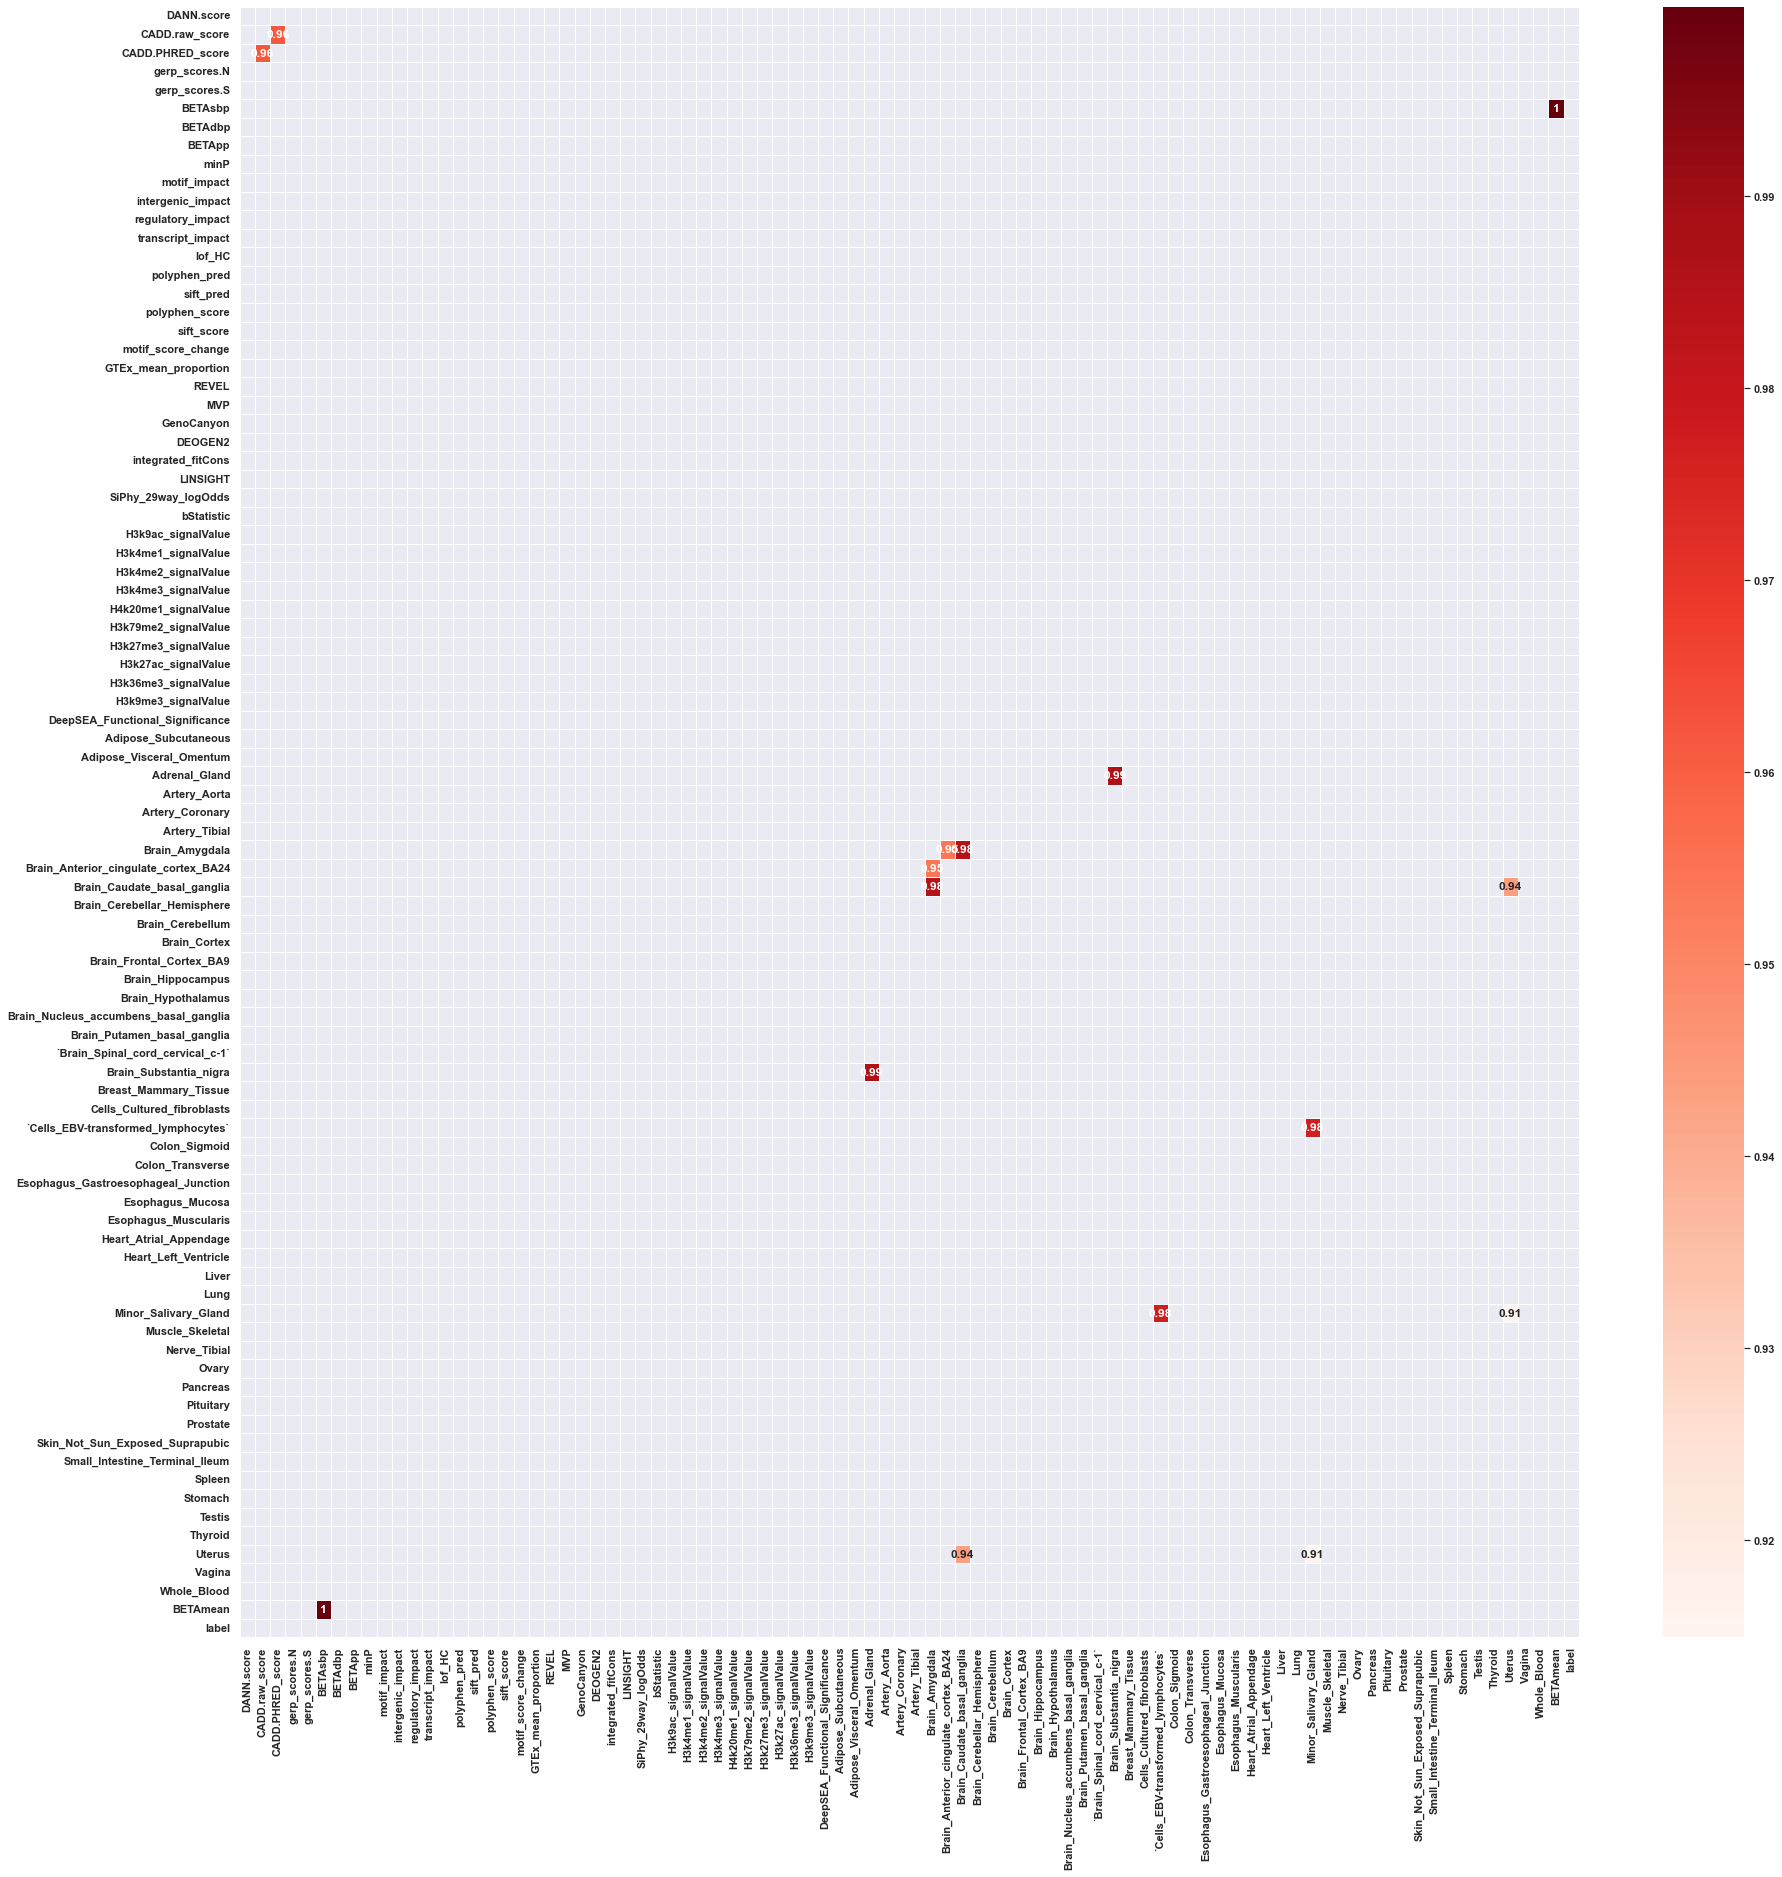

In [43]:
dfCorr = features.corr()
filteredDf = dfCorr[((dfCorr >= .9) | (dfCorr <= -.9)) & (dfCorr !=1.000)]
plt.figure(figsize=(30,30))
plt.tight_layout()
sns.set(font_scale=1)
sns.heatmap(filteredDf, linewidths=0.5, annot=True, cmap="Reds")
plt.show()